## Imports and setup

This section imports all the libraries required for data analysis, visualization, model training, evaluation, and probability calibration.

- **NumPy** and **Pandas** are used for numerical operations and data handling.
- **Matplotlib** is used for all visualizations.
- **Scikit-learn** provides tools for data splitting, preprocessing, modeling, evaluation, and calibration.
- Display options are adjusted to improve the readability of tables in the notebook.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, precision_recall_curve, roc_curve,
    brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

## Dataset path

This variable defines the file path of the dataset used throughout the notebook.  
Please make sure that the dataset file name and location match this path.


In [2]:
DATASET_PATH = "./input/dataset.csv"

## Load the dataset

The dataset is loaded from the specified file path into a Pandas DataFrame.  
The first rows are displayed to verify that the data has been loaded correctly.


In [3]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Student_ID,Age,Gender,Department,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level,Depression
0,1001,22,Female,Science,3.50,7.3,3.3,3.4,114,5,False
1,1002,20,Male,Engineering,2.72,5.5,7.2,6.0,142,2,False
2,1003,20,Male,Medical,3.01,5.4,2.3,1.8,137,3,False
3,1004,21,Male,Engineering,3.63,8.1,2.0,4.6,130,3,False
4,1005,19,Male,Arts,3.14,6.8,2.6,4.3,4,6,False


## Dataset overview

This step provides a quick overview of the dataset structure, data types, and basic descriptive statistics to understand the size and composition of the data.


In [33]:
print("Shape:", df.shape)
display(df.info())
display(df.describe(include="all").T.head(20))

Shape: (100000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Student_ID          100000 non-null  int64  
 1   Age                 100000 non-null  int64  
 2   Gender              100000 non-null  object 
 3   Department          100000 non-null  object 
 4   CGPA                100000 non-null  float64
 5   Sleep_Duration      100000 non-null  float64
 6   Study_Hours         100000 non-null  float64
 7   Social_Media_Hours  100000 non-null  float64
 8   Physical_Activity   100000 non-null  int64  
 9   Stress_Level        100000 non-null  int64  
 10  Depression          100000 non-null  bool   
dtypes: bool(1), float64(4), int64(4), object(2)
memory usage: 7.7+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Student_ID,100000.0,NaN,NaN,NaN,51000.5,28867.657797,1001.0,26000.75,51000.5,76000.25,101000.0
Age,100000.0,NaN,NaN,NaN,21.00901,2.000382,18.0,19.0,21.0,23.0,24.0
Gender,100000,2,Male,50120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department,100000,5,Science,20071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CGPA,100000.0,NaN,NaN,NaN,2.898316,0.53224,1.56,2.45,2.9,3.35,4.0
Sleep_Duration,100000.0,NaN,NaN,NaN,6.996425,1.498682,3.0,6.0,7.0,8.0,12.0
Study_Hours,100000.0,NaN,NaN,NaN,4.509517,1.976076,0.0,3.2,4.5,5.8,12.8
Social_Media_Hours,100000.0,NaN,NaN,NaN,3.503288,1.486852,0.0,2.5,3.5,4.5,10.0
Physical_Activity,100000.0,NaN,NaN,NaN,74.35318,43.366963,0.0,37.0,74.0,112.0,149.0
Stress_Level,100000.0,NaN,NaN,NaN,4.13166,1.424151,2.0,3.0,4.0,5.0,10.0


## Data quality checks

This step checks for missing values and duplicated rows to ensure the dataset is clean before further analysis and modeling.


In [34]:
# Missing values
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].head(20))

# Duplicates
print("Duplicate rows:", df.duplicated().sum())

Series([], dtype: int64)

Duplicate rows: 0


## Target variable distribution

This section converts the target variable to a numeric format and analyzes its class distribution, highlighting potential class imbalance through both tabular and visual inspection.


,count,rate
Depression,,
0,89938,0.89938
1,10062,0.10062


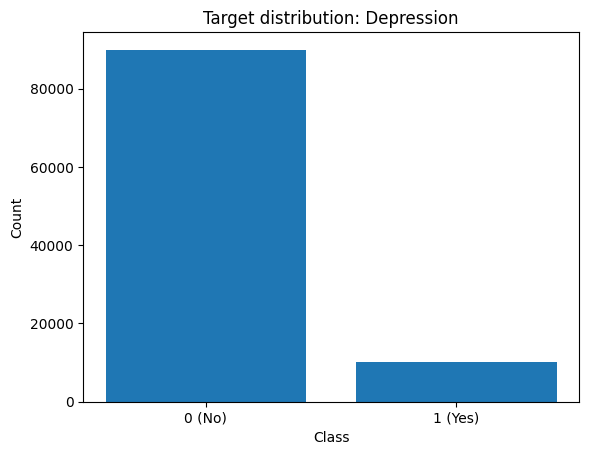

In [35]:
# Ensure the target is numeric 0/1
y_raw = df["Depression"]
y = y_raw.astype(int) if y_raw.dtype != int else y_raw

counts = y.value_counts().sort_index()
rates = y.value_counts(normalize=True).sort_index()

display(pd.DataFrame({"count": counts, "rate": rates}))

# Plot target distribution
plt.figure()
plt.bar(["0 (No)", "1 (Yes)"], [counts.get(0, 0), counts.get(1, 0)])
plt.title("Target distribution: Depression")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Feature preparation

In this step, the target and identifier columns are removed, and the remaining features are separated into categorical and numeric variables to prepare for preprocessing and modeling.


In [36]:
# Drop an ID column if present
X = df.drop(columns=["Depression", "Student_ID"], errors="ignore")
y = df["Depression"].astype(int)

# Identify categorical vs numeric columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

display(X.head())

Categorical columns: ['Gender', 'Department']
Numeric columns: ['Age', 'CGPA', 'Sleep_Duration', 'Study_Hours', 'Social_Media_Hours', 'Physical_Activity', 'Stress_Level']


,Age,Gender,Department,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level
0,22,Female,Science,3.50,7.3,3.3,3.4,114,5
1,20,Male,Engineering,2.72,5.5,7.2,6.0,142,2
2,20,Male,Medical,3.01,5.4,2.3,1.8,137,3
3,21,Male,Engineering,3.63,8.1,2.0,4.6,130,3
4,19,Male,Arts,3.14,6.8,2.6,4.3,4,6


## Numeric feature distributions

This section visualizes the distributions of selected numeric features to understand their ranges, shapes, and potential outliers.


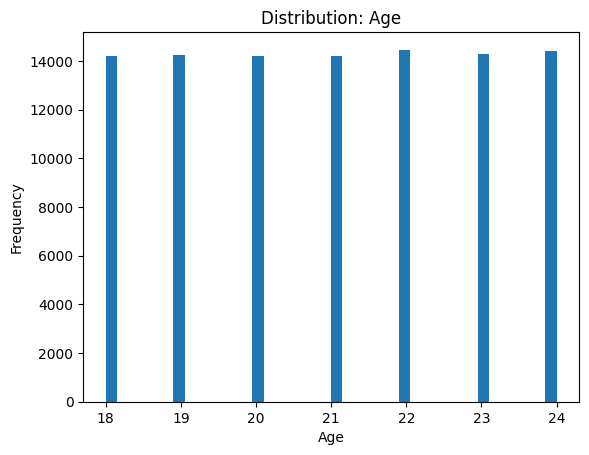

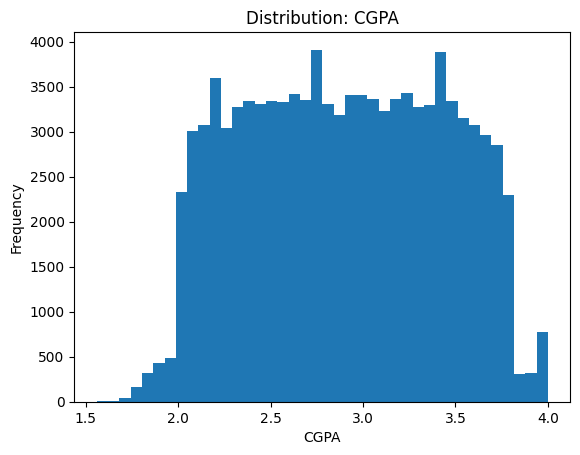

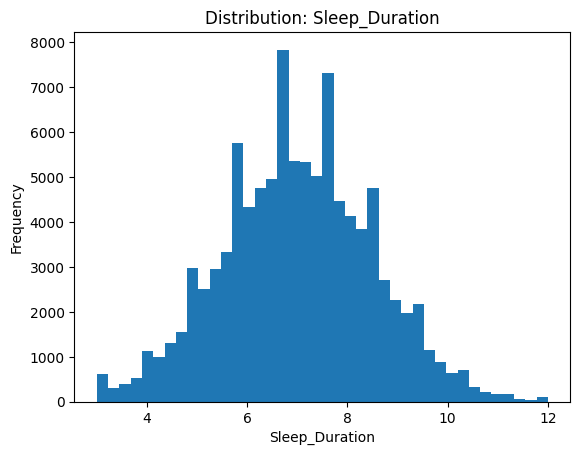

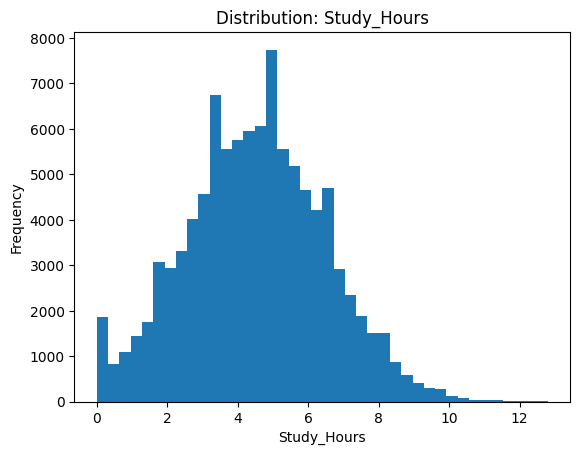

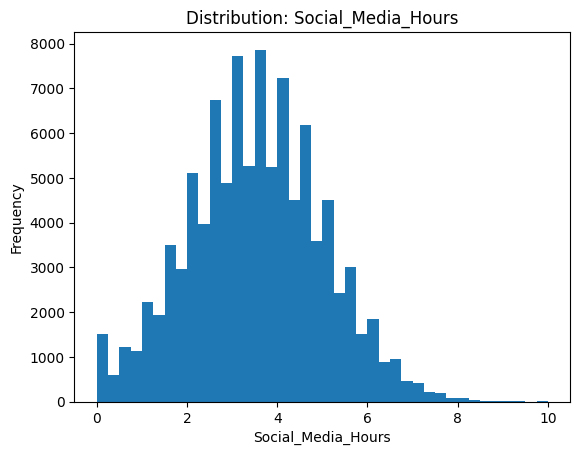

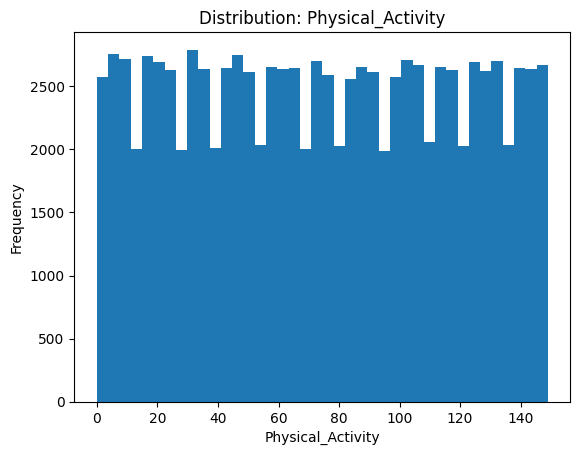

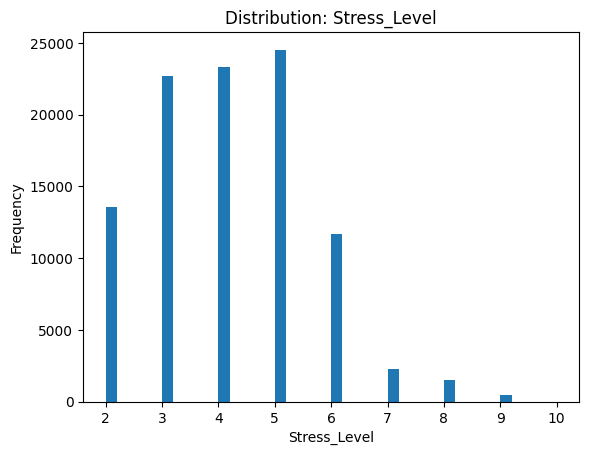

In [37]:
# You can add/remove columns here depending on what you want to visualize
example_numeric = [c for c in ["Age", "CGPA", "Sleep_Duration", "Study_Hours", "Social_Media_Hours", "Physical_Activity", "Stress_Level"] if c in X.columns]

for col in example_numeric:
    plt.figure()
    plt.hist(X[col].values, bins=40)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

## Correlation matrix

This section visualizes the Pearson correlation between numeric features, helping to identify linear relationships and potential multicollinearity.


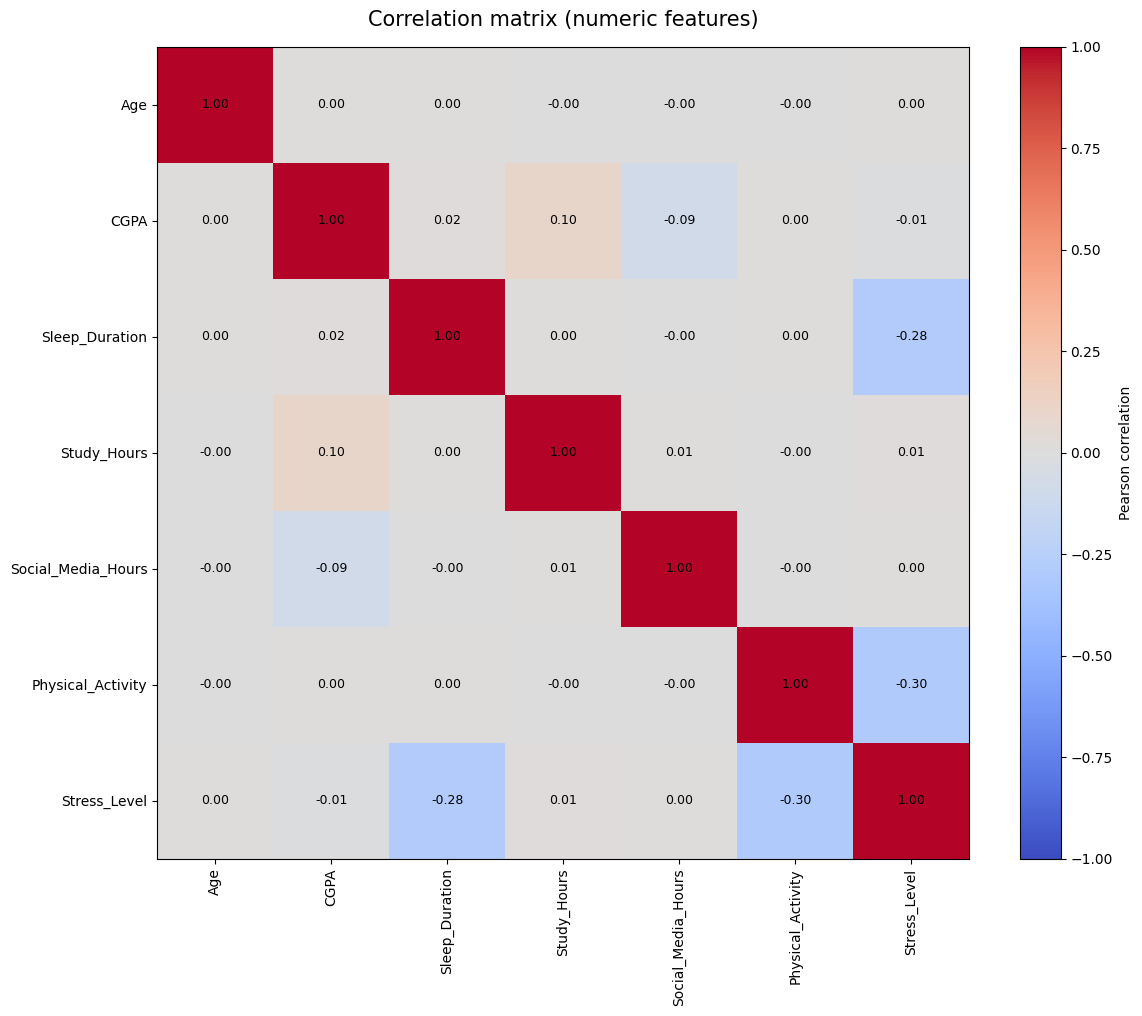

In [38]:
numeric_df = X[num_cols].copy()
corr = numeric_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))

im = plt.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Correlation matrix (numeric features)", fontsize=15, pad=15)

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=10)
plt.yticks(range(len(corr.index)), corr.index, fontsize=10)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=9, color="black")

cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Pearson correlation", rotation=90)

plt.tight_layout()
plt.show()


## Train–validation–test split

The dataset is split into training, validation, and test sets with stratification to preserve class proportions and enable fair model evaluation and threshold selection.


In [39]:
# We will use:
# - Train set: model fitting
# - Validation set: threshold selection (mathematically)
# - Test set: final unbiased evaluation

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, random_state=42, stratify=y_trainval
)
# 0.1765 * 0.85 ≈ 0.15, so we get ~70/15/15

print("Train:", X_train.shape, y_train.mean())
print("Val:  ", X_val.shape, y_val.mean())
print("Test: ", X_test.shape, y_test.mean())

Train: (69997, 9) 0.10061859793991171
Val:   (15003, 9) 0.10064653735919482
Test:  (15000, 9) 0.1006


## Feature preprocessing

Categorical features are one-hot encoded while numeric features are passed through unchanged using a ColumnTransformer, ensuring consistent preprocessing for all models.


In [40]:
# One-hot encode categorical columns; pass numeric columns through unchanged
# Note: We set sparse_output=False so GradientBoosting can work (it needs dense arrays).
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

## Model definition and training

In this section, we define and train two tree-based ensemble models:
**Random Forest** and **Gradient Boosting**.

### Random Forest
- `RandomForestClassifier` is an ensemble method that trains many decision trees in parallel.
- Each tree is built on a bootstrap sample of the data and considers a random subset of features.
- Key parameters used:
  - `n_estimators=600`: number of trees in the forest, providing stable predictions.
  - `min_samples_leaf=2`: prevents overly complex trees and helps reduce overfitting.
  - `class_weight="balanced"`: compensates for class imbalance by giving more importance to the minority class.
  - `n_jobs=-1`: uses all available CPU cores for faster training.
  - `random_state=42`: ensures reproducibility.

### Gradient Boosting
- `GradientBoostingClassifier` builds trees sequentially.
- Each new tree focuses on correcting the errors made by previous trees.
- This approach often captures complex patterns but can be more sensitive to hyperparameters.
- A fixed `random_state` is used for reproducibility.

### Pipelines
- Both models are wrapped inside a `Pipeline` together with the preprocessing step.
- This ensures that preprocessing and model training are applied consistently.
- Pipelines prevent data leakage and simplify both training and prediction.

### Model training
- Both pipelines are trained using the same training dataset.
- This allows for a fair comparison between Random Forest and Gradient Boosting under identical preprocessing conditions.

At this stage, both models are fitted and ready to be evaluated on validation and test data.


## Validation metrics

This section computes and compares multiple evaluation metrics on the validation set, using predicted probabilities and a fixed decision threshold.


In [41]:
def compute_metrics(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "threshold": threshold,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
    }

rf_val_proba = rf_pipe.predict_proba(X_val)[:, 1]
gb_val_proba = gb_pipe.predict_proba(X_val)[:, 1]

rf_val_metrics = compute_metrics(y_val, rf_val_proba, threshold=0.5)
gb_val_metrics = compute_metrics(y_val, gb_val_proba, threshold=0.5)

display(pd.DataFrame([rf_val_metrics, gb_val_metrics], index=["RandomForest (val)", "GradientBoosting (val)"]))

,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
RandomForest (val),0.5,0.99940,0.994075,1.000000,0.997029,0.999999,0.999988
GradientBoosting (val),0.5,0.90022,0.586667,0.029139,0.055521,0.726828,0.261104


## ROC and Precision–Recall curves

This section visualizes ROC and Precision–Recall curves on the validation set to compare the ranking performance of the models independently of a fixed decision threshold.


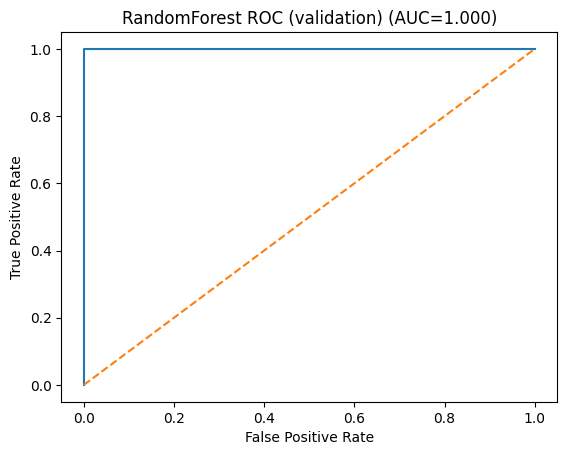

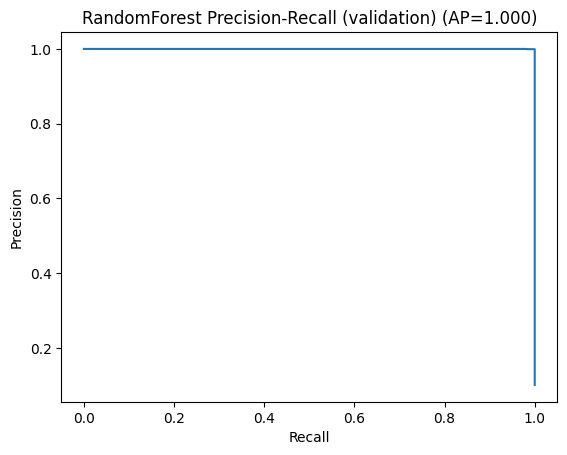

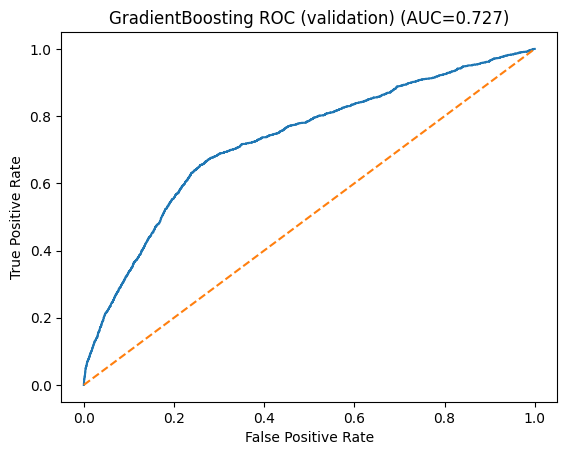

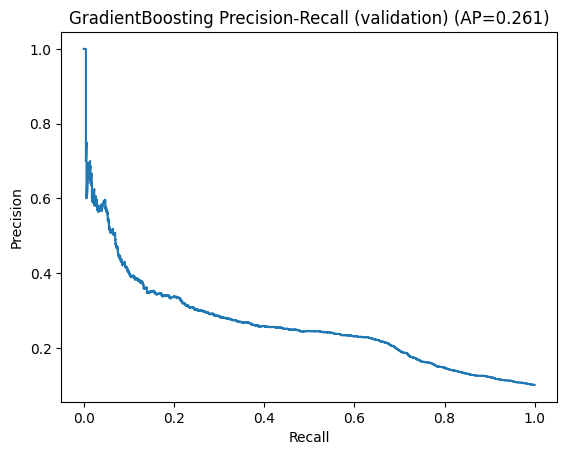

In [42]:
def plot_roc(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"{title} (AUC={auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

def plot_pr(y_true, y_proba, title):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision)
    plt.title(f"{title} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

plot_roc(y_val, rf_val_proba, "RandomForest ROC (validation)")
plot_pr(y_val, rf_val_proba, "RandomForest Precision-Recall (validation)")

plot_roc(y_val, gb_val_proba, "GradientBoosting ROC (validation)")
plot_pr(y_val, gb_val_proba, "GradientBoosting Precision-Recall (validation)")

## Optimal threshold selection

This section selects the optimal decision threshold on the validation set using two mathematical criteria: maximum F1-score and Youden’s J statistic.


In [43]:
def find_best_threshold_f1(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # precision_recall_curve returns thresholds of length n-1; align safely
    f1_scores = (2 * precision * recall) / (precision + recall + 1e-12)
    best_idx = int(np.nanargmax(f1_scores))
    # If best_idx is last element (no threshold), clamp
    if best_idx >= len(thresholds):
        best_idx = len(thresholds) - 1
    best_thr = float(thresholds[best_idx])
    return best_thr, float(f1_scores[best_idx])

def find_best_threshold_youden(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    j = tpr - fpr
    best_idx = int(np.nanargmax(j))
    return float(thresholds[best_idx]), float(j[best_idx])

rf_thr_f1, rf_best_f1 = find_best_threshold_f1(y_val, rf_val_proba)
rf_thr_j, rf_best_j = find_best_threshold_youden(y_val, rf_val_proba)

gb_thr_f1, gb_best_f1 = find_best_threshold_f1(y_val, gb_val_proba)
gb_thr_j, gb_best_j = find_best_threshold_youden(y_val, gb_val_proba)

summary = pd.DataFrame({
    "best_thr_f1": [rf_thr_f1, gb_thr_f1],
    "best_f1": [rf_best_f1, gb_best_f1],
    "best_thr_youden": [rf_thr_j, gb_thr_j],
    "best_youden_j": [rf_best_j, gb_best_j],
}, index=["RandomForest", "GradientBoosting"])

display(summary)

,best_thr_f1,best_f1,best_thr_youden,best_youden_j
RandomForest,0.541626,0.999669,0.541626,0.999926
GradientBoosting,0.183233,0.335393,0.134805,0.395805


## Threshold sweep analysis

This section evaluates model performance across a range of decision thresholds, visualizing how the F1-score changes to support informed threshold selection.


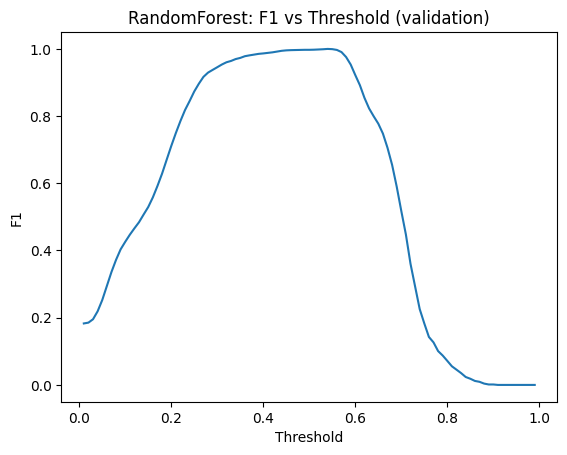

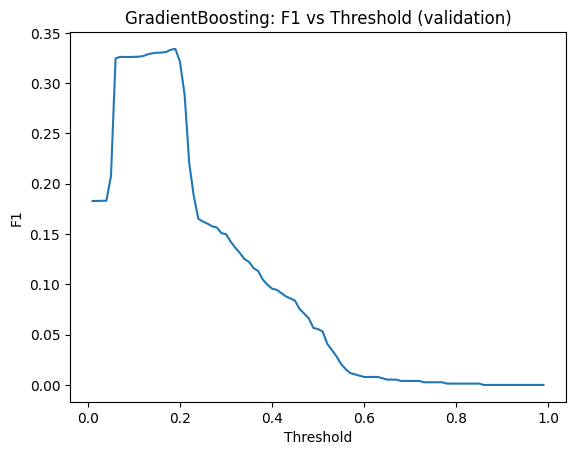

In [44]:
def threshold_sweep(y_true, y_proba, thresholds=np.linspace(0.01, 0.99, 99)):
    rows = []
    for t in thresholds:
        rows.append(compute_metrics(y_true, y_proba, threshold=float(t)))
    return pd.DataFrame(rows)

rf_sweep = threshold_sweep(y_val, rf_val_proba)
gb_sweep = threshold_sweep(y_val, gb_val_proba)

# Plot F1 vs threshold for each model
plt.figure()
plt.plot(rf_sweep["threshold"], rf_sweep["f1"])
plt.title("RandomForest: F1 vs Threshold (validation)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.show()

plt.figure()
plt.plot(gb_sweep["threshold"], gb_sweep["f1"])
plt.title("GradientBoosting: F1 vs Threshold (validation)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.show()

## Final evaluation on the test set

This section evaluates both models on the held-out test set using thresholds selected on the validation data, providing an unbiased assessment of final performance.


In [52]:
def evaluate_on_test(pipe, X_test, y_test, threshold, name="Model"):
    proba = pipe.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, proba, threshold=threshold)
    cm = confusion_matrix(y_test, (proba >= threshold).astype(int))
    return metrics, cm, proba

# We'll use the F1-optimal threshold found on the validation set (common educational choice).
rf_test_metrics, rf_cm, rf_test_proba = evaluate_on_test(rf_pipe, X_test, y_test, rf_thr_f1, "RandomForest")
gb_test_metrics, gb_cm, gb_test_proba = evaluate_on_test(gb_pipe, X_test, y_test, gb_thr_f1, "GradientBoosting")

display(pd.DataFrame([rf_test_metrics, gb_test_metrics], index=[f"RandomForest (thr={rf_thr_f1:.3f})", f"GradientBoosting (thr={gb_thr_f1:.3f})"]))

print("RandomForest confusion matrix:\n", rf_cm)
print("\nGradientBoosting confusion matrix:\n", gb_cm)

,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
RandomForest (thr=0.542),0.541626,0.898800,0.460177,0.034460,0.064118,0.699814,0.224318
GradientBoosting (thr=0.183),0.183233,0.747333,0.220534,0.596421,0.322004,0.699681,0.231828


RandomForest confusion matrix:
 [[13430    61]
 [ 1457    52]]

GradientBoosting confusion matrix:
 [[10310  3181]
 [  609   900]]


## Probability calibration

In this step, the models are retrained on the combined training and validation set and then calibrated using cross-validation to improve the reliability of predicted probabilities.


In [46]:
# Refit base models on train+val before calibration (common practice)
rf_pipe_full = Pipeline(steps=[("prep", preprocess), ("model", rf_model)])
gb_pipe_full = Pipeline(steps=[("prep", preprocess), ("model", gb_model)])

X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

rf_pipe_full.fit(X_train_full, y_train_full)
gb_pipe_full.fit(X_train_full, y_train_full)

# Calibrators wrap the full pipeline
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cal_sig = CalibratedClassifierCV(rf_pipe_full, method="sigmoid", cv=cv)
rf_cal_iso = CalibratedClassifierCV(rf_pipe_full, method="isotonic", cv=cv)

gb_cal_sig = CalibratedClassifierCV(gb_pipe_full, method="sigmoid", cv=cv)
gb_cal_iso = CalibratedClassifierCV(gb_pipe_full, method="isotonic", cv=cv)

rf_cal_sig.fit(X_train_full, y_train_full)
rf_cal_iso.fit(X_train_full, y_train_full)

gb_cal_sig.fit(X_train_full, y_train_full)
gb_cal_iso.fit(X_train_full, y_train_full)

print("Calibrated models fitted.")

/opt/miniconda3/envs/data/lib/python3.13/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/opt/miniconda3/envs/data/lib/python3.13/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/opt/miniconda3/envs/data/lib/python3.13/site-packages/sklearn/calibration.py:849: RuntimeWarning: invalid value encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/opt/miniconda3/envs/data/lib/python3.13/site-packages/sklearn/calibration.py:849: RuntimeWarning: divide by zero encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/opt/miniconda3/envs/data/lib/python3.13/site-packages/sklearn/calibration.py:849: RuntimeWarning: overflow encountered in matmul
  grad = np.asarray([-g @ F, -g.sum()], dtype=np.float64)
/opt/miniconda3/envs/data/lib/python3.13/si

Calibrated models fitted.


## Probability calibration evaluation

This section evaluates the quality of predicted probabilities using calibration curves and the Brier score, comparing base and calibrated models on the test set.


,roc_auc,pr_auc,brier
model,,,
GB isotonic,0.700061,0.234633,0.083606
GB sigmoid,0.700953,0.235022,0.083640
GB base,0.699681,0.231828,0.083715
RF isotonic,0.702051,0.227829,0.084279
RF sigmoid,0.700732,0.227527,0.084809
RF base,0.699814,0.224318,0.088580


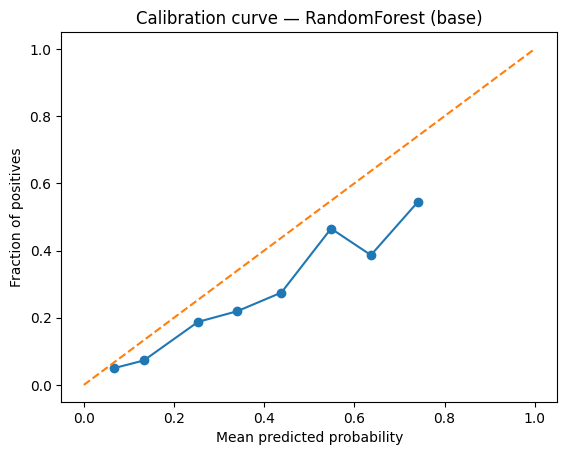

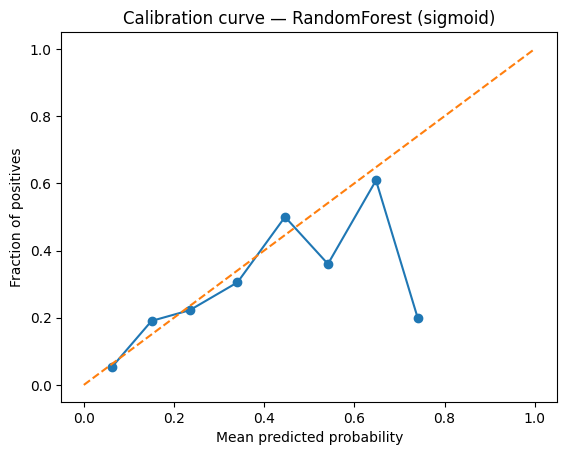

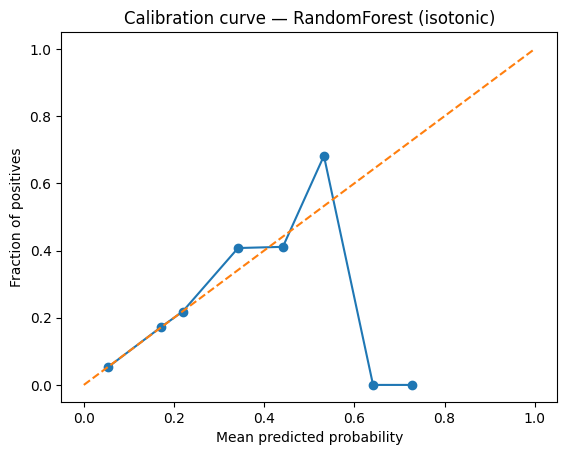

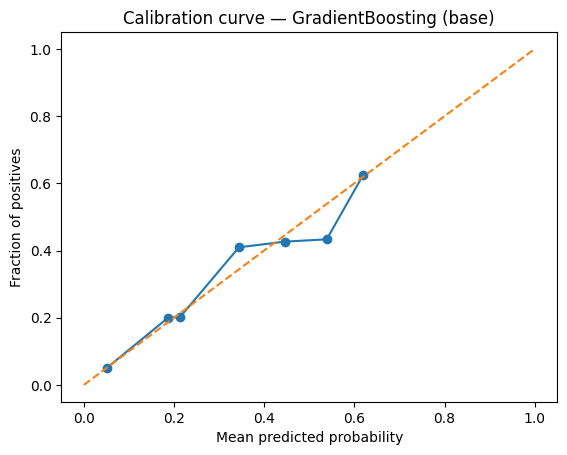

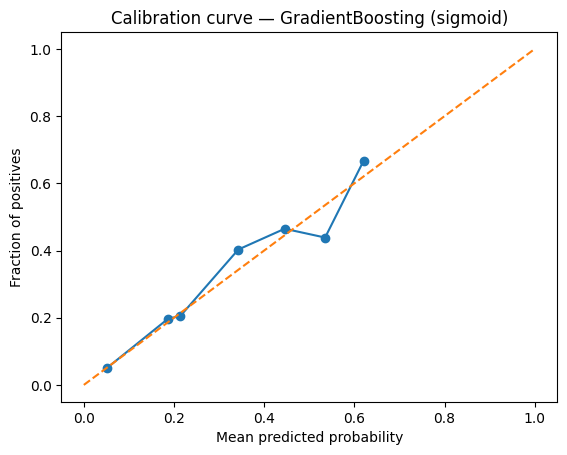

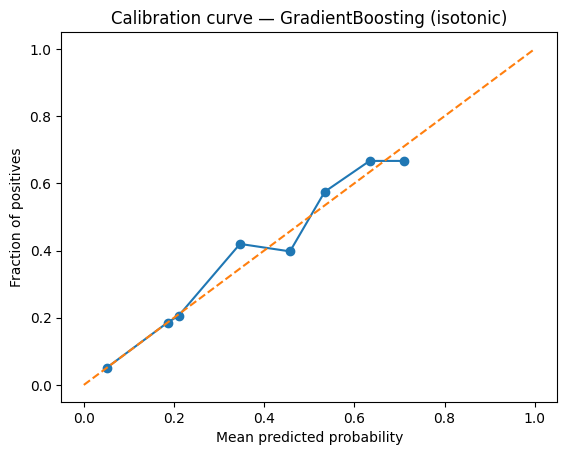

In [47]:
def plot_calibration(y_true, y_proba, title):
    frac_pos, mean_pred = calibration_curve(y_true, y_proba, n_bins=10, strategy="uniform")
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(title)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.show()

def calibration_report(y_true, y_proba):
    return {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
        "brier": brier_score_loss(y_true, y_proba),
    }

# Probabilities on test set
rf_base = rf_pipe_full.predict_proba(X_test)[:, 1]
rf_sig  = rf_cal_sig.predict_proba(X_test)[:, 1]
rf_iso  = rf_cal_iso.predict_proba(X_test)[:, 1]

gb_base = gb_pipe_full.predict_proba(X_test)[:, 1]
gb_sig  = gb_cal_sig.predict_proba(X_test)[:, 1]
gb_iso  = gb_cal_iso.predict_proba(X_test)[:, 1]

report = pd.DataFrame([
    {"model": "RF base", **calibration_report(y_test, rf_base)},
    {"model": "RF sigmoid", **calibration_report(y_test, rf_sig)},
    {"model": "RF isotonic", **calibration_report(y_test, rf_iso)},
    {"model": "GB base", **calibration_report(y_test, gb_base)},
    {"model": "GB sigmoid", **calibration_report(y_test, gb_sig)},
    {"model": "GB isotonic", **calibration_report(y_test, gb_iso)},
]).set_index("model")

display(report.sort_values("brier"))

plot_calibration(y_test, rf_base, "Calibration curve — RandomForest (base)")
plot_calibration(y_test, rf_sig,  "Calibration curve — RandomForest (sigmoid)")
plot_calibration(y_test, rf_iso,  "Calibration curve — RandomForest (isotonic)")

plot_calibration(y_test, gb_base, "Calibration curve — GradientBoosting (base)")
plot_calibration(y_test, gb_sig,  "Calibration curve — GradientBoosting (sigmoid)")
plot_calibration(y_test, gb_iso,  "Calibration curve — GradientBoosting (isotonic)")

## Threshold selection with calibrated probabilities

This section selects the F1-optimal decision threshold on the validation set using calibrated probabilities and then evaluates the calibrated models on the test set.


In [ ]:
# As an educational example: choose threshold that maximizes F1 on the VALIDATION set using calibrated model
# We'll use sigmoid-calibrated versions.

# Get calibrated probabilities on validation set
rf_val_cal = rf_cal_sig.predict_proba(X_val)[:, 1]
gb_val_cal = gb_cal_sig.predict_proba(X_val)[:, 1]

rf_thr_cal_f1, rf_best_cal_f1 = find_best_threshold_f1(y_val, rf_val_cal)
gb_thr_cal_f1, gb_best_cal_f1 = find_best_threshold_f1(y_val, gb_val_cal)

print(f"RF sigmoid best F1 threshold on val: {rf_thr_cal_f1:.3f} (F1={rf_best_cal_f1:.3f})")
print(f"GB sigmoid best F1 threshold on val: {gb_thr_cal_f1:.3f} (F1={gb_best_cal_f1:.3f})")

# Evaluate on test
rf_test_metrics_cal = compute_metrics(y_test, rf_sig, threshold=rf_thr_cal_f1)
gb_test_metrics_cal = compute_metrics(y_test, gb_sig, threshold=gb_thr_cal_f1)

display(pd.DataFrame([rf_test_metrics_cal, gb_test_metrics_cal], index=[
    f"RF sigmoid (thr={rf_thr_cal_f1:.3f})",
    f"GB sigmoid (thr={gb_thr_cal_f1:.3f})"
]))

RF sigmoid best F1 threshold on val: 0.419 (F1=0.996)
GB sigmoid best F1 threshold on val: 0.188 (F1=0.339)


,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
RF sigmoid (thr=0.419),0.418502,0.898733,0.463768,0.042412,0.077717,0.700732,0.227527
GB sigmoid (thr=0.188),0.188209,0.757800,0.223581,0.569251,0.321061,0.700953,0.235022


## Feature importance analysis

This section examines feature importance from the Random Forest model to identify which variables contribute most to the predictions.


num__CGPA                      0.271765
num__Physical_Activity         0.139339
num__Sleep_Duration            0.138506
num__Study_Hours               0.132815
num__Social_Media_Hours        0.125344
num__Stress_Level              0.070034
num__Age                       0.058150
cat__Department_Engineering    0.009680
cat__Department_Business       0.009417
cat__Department_Medical        0.009388
cat__Department_Arts           0.009290
cat__Department_Science        0.009006
cat__Gender_Female             0.008645
cat__Gender_Male               0.008623
dtype: float64

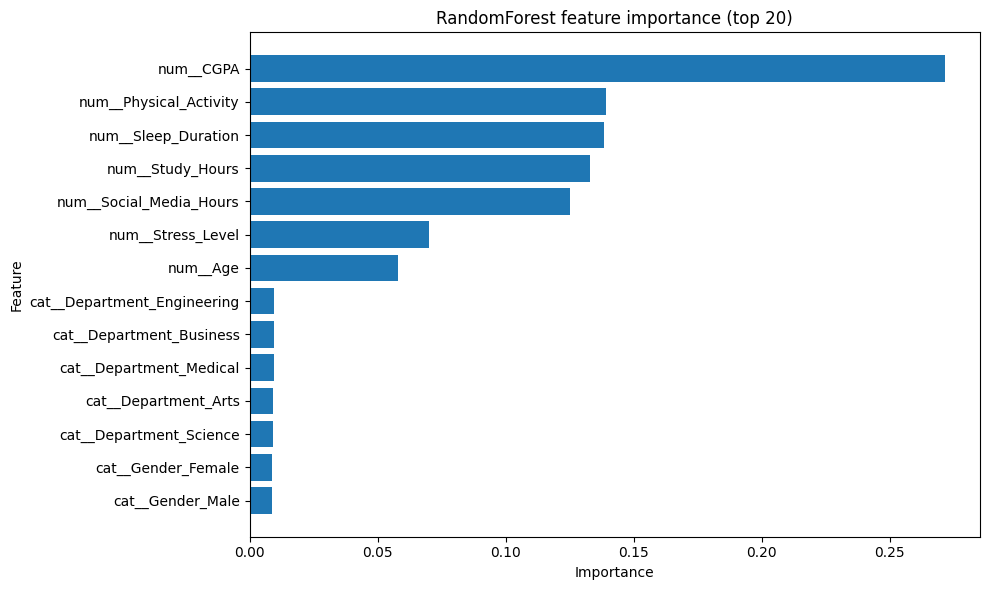

In [49]:
# Feature importance is easiest to interpret for RandomForest.
# With OneHotEncoding, categorical columns expand into multiple features.

rf_final = rf_pipe_full.named_steps["model"]
prep = rf_pipe_full.named_steps["prep"]
feature_names = prep.get_feature_names_out()

importances = pd.Series(rf_final.feature_importances_, index=feature_names).sort_values(ascending=False)

display(importances.head(25))

# Plot top 20
top = importances.head(20)
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(top.index.tolist())), list(reversed(top.values.tolist())))
plt.title("RandomForest feature importance (top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Manual prediction (custom input)

This section creates a single-row DataFrame from manually entered values and aligns it to the training feature columns, so it can be passed directly to the fitted pipeline for pred


In [50]:
# =========================
# Manual prediction
# =========================

# Choose the model to use
# Recommended: calibrated model for realistic probabilities
final_model = rf_cal_sig   # or gb_cal_sig if you prefer GradientBoosting

# Decision threshold (chosen on validation set)
threshold = rf_thr_cal_f1

# -------------------------
# MANUALLY ENTER DATA HERE
# -------------------------
user_data = {
    "Age": 21,
    "Gender": "Male",
    "Department": "Engineering",
    "CGPA": 2.2,
    "Sleep_Duration": 4.5,
    "Study_Hours": 3.0,
    "Social_Media_Hours": 4.0,
    "Physical_Activity": 120,
    "Stress_Level": 9,
}

# Create DataFrame
user_df = pd.DataFrame([user_data])

# Align columns with training data
for col in X.columns:
    if col not in user_df.columns:
        user_df[col] = np.nan

user_df = user_df[X.columns]

display(user_df)


,Age,Gender,Department,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level
0,21,Male,Engineering,2.2,4.5,3.0,4.0,120,9


## Final prediction output

This section generates the predicted probability and final class label for the manually provided input using the selected decision threshold.


In [51]:
# Predict probability
probability = final_model.predict_proba(user_df)[0, 1]

# Apply threshold
prediction = int(probability >= threshold)

print("=== Prediction ===")
print(f"Predicted probability of Depression: {probability*100:.2f}%")
print(f"Decision threshold: {threshold:.2f}")

if prediction == 1:
    print("Predicted class: 1 (At risk)")
else:
    print("Predicted class: 0 (Not at risk)")


=== Prediction ===
Predicted probability of Depression: 71.26%
Decision threshold: 0.42
Predicted class: 1 (At risk)
